# Exercícios Aula 5 - Thiago Garbin

In [32]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Exercício 1 - Identificação de
# Comentários Sarcásticos do Reddit

### Pré-processamento (preliminar)

In [2]:
# 1. Importe os dados;

# Comentários normais:
df_comment0 = pd.read_csv('COMENTARIOS_0.csv')

# Comentários sarcásticos:
df_comment1 = pd.read_csv('COMENTARIOS_1.csv')

In [3]:
# 2. Os comentários normais estão no arquivo de sufixo _0 e os sarcásticos estão no _1. Concatene
# ambos para obter apenas um dataframe completo.

df_comments = pd.concat([df_comment0, df_comment1], axis=0)

df_comments

,label,comment,author,subreddit,score,date,parent_comment
0,0,NC and NH.,Trumpbart,politics,2.0,2016-10,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.0,2016-11,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.0,2016-09,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.0,2016-10,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.0,2016-12,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...
505408,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2.0,2009-04,"No one is calling this an engineered pathogen,..."
505409,1,"whatever you do, don't vote green!",BCHarvey,climate,1.0,2009-05,In a move typical of their recent do-nothing a...
505410,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1.0,2009-01,Screw the Disabled--I've got to get to Church ...
505411,1,The Slavs got their own country - it is called...,catsi,worldnews,1.0,2009-01,I've always been unsettled by that. I hear a l...


In [4]:
# Alterando índice
df_comments.index = [i for i in range(len(df_comments))]

In [5]:
# 3. Há outliers na variável score. Trate-os substituindo pela média dos não outliers da série;

print(df_comments['score'].sort_values().head())
print(df_comments['score'].sort_values(ascending=False).head())
print(df_comments['score'].mean())

642564   -507.0
719171   -312.0
51637    -298.0
538990   -261.0
785916   -209.0
Name: score, dtype: float64
132       9999999.0
122       1000000.0
566741       9070.0
572797       7563.0
63485        5818.0
Name: score, dtype: float64
17.767917595778485


In [6]:
df_comments['score'] = np.where(df_comments['score'] > 9070,
                                df_comments['score'][df_comments['score'] <= 9070].mean(),
                                df_comments['score'])

print(df_comments['score'].sort_values(ascending=False).head())
print(df_comments['score'].mean())

566741    9070.0
572797    7563.0
63485     5818.0
31584     5629.0
357653    5163.0
Name: score, dtype: float64
6.885699728932946


In [7]:
# 4. Há valores ausentes nas variáveis subreddit e score. Analise os dados e trate da forma que você
# julgar melhor, usando alguma das técnicas que aprendemos em aula;

# VERIFICANDO A QUANTIDADE DE VALORES AUSENTES NO DATAFRAME

print(df_comments.isna().sum())

print('\nQuantidade e percentual de valores ausentes em subreddit:')
print(df_comments['subreddit'].isna().sum())
print(df_comments['subreddit'].isna().sum() / df_comments['subreddit'].shape[0])

print('\nQuantidade e percentual de valores ausentes em score:')
print(df_comments['score'].isna().sum())
print(df_comments['score'].isna().sum() / df_comments['score'].shape[0])

label              0
comment           53
author             0
subreddit          3
score              4
date               0
parent_comment     0
dtype: int64

Quantidade e percentual de valores ausentes em subreddit:
3
2.9678698411002486e-06

Quantidade e percentual de valores ausentes em score:
4
3.9571597881336646e-06


In [8]:
# Como a quantidade de valores nulos nas variáveis subreddit e score é bastante pequena,
# escolheu-se por remover as linhas em que esses valores nulos se encontram.
# Além disso, verificou-se que havia também uma pequena quantidade de valores nulos
# na variável comment. Como possivelmente essa variável terá grande importância mais a frente
# e não seria o mais correto arbirtrar um valor para ela, então também julgou-se apropriado
# remover as linhas em que esses valores nulos se encontram.

df_comments.dropna(inplace=True)

# Novamente alterando índice
df_comments.index = [i for i in range(len(df_comments))]

df_comments

,label,comment,author,subreddit,score,date,parent_comment
0,0,NC and NH.,Trumpbart,politics,2.0,2016-10,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.0,2016-11,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.0,2016-09,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.0,2016-10,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.0,2016-12,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...
1010761,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2.0,2009-04,"No one is calling this an engineered pathogen,..."
1010762,1,"whatever you do, don't vote green!",BCHarvey,climate,1.0,2009-05,In a move typical of their recent do-nothing a...
1010763,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1.0,2009-01,Screw the Disabled--I've got to get to Church ...
1010764,1,The Slavs got their own country - it is called...,catsi,worldnews,1.0,2009-01,I've always been unsettled by that. I hear a l...


In [9]:
# 5. No dataframe que estamos trabalhando, crie quatro variáveis dummies, conforme abaixo:
# a. comment_wcount: quantidade de palavras contidas na variável comment;
# b. parent_comment_wcount: quantidade de palavras contidas na variável parent_comment;
# c. comment_char: quantidade de caracteres contidas na variável comment;
# d. parent_comment_char: quantidade de caracteres contidas na variável parent_comment.

df_comments['comment_wcount'] = df_comments['comment'].str.split().str.len()
df_comments['parent_comment_wcount'] = df_comments['parent_comment'].str.split().str.len()

df_comments['comment_char'] = df_comments['comment'].str.len()
df_comments['parent_comment_char'] = df_comments['parent_comment'].str.len()

df_comments.head()

,label,comment,author,subreddit,score,date,parent_comment,comment_wcount,parent_comment_wcount,comment_char,parent_comment_char
0,0,NC and NH.,Trumpbart,politics,2.0,2016-10,"Yeah, I get that argument. At this point, I'd ...",3,17,10,80
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.0,2016-11,The blazers and Mavericks (The wests 5 and 6 s...,14,27,74,134
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.0,2016-09,They're favored to win.,19,4,121,23
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.0,2016-10,deadass don't kill my buzz,12,5,60,26
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.0,2016-12,Yep can confirm I saw the tool they use for th...,7,18,31,85


### Análise de dados (preliminar)

In [10]:
# 1. Percentualmente, qual o volume de comentários sarcásticos?

# Com os dados brutos o percentual de comentários sarcásticos seria 50%. Entretanto,
# após a remoção de linhas com valores nulos esse percentual diminuiu levemente.

((df_comments['label'] == 1).sum() / df_comments['label'].shape[0]) * 100

# 49,99%

49.99851597699171

In [11]:
# 2. Qual o autor que mais comenta com sarcasmo?

df_comments[df_comments['label'] == 1].groupby('author')['comment']\
.count().sort_values(ascending=False).head(1)

author
Biffingston    422
Name: comment, dtype: int64

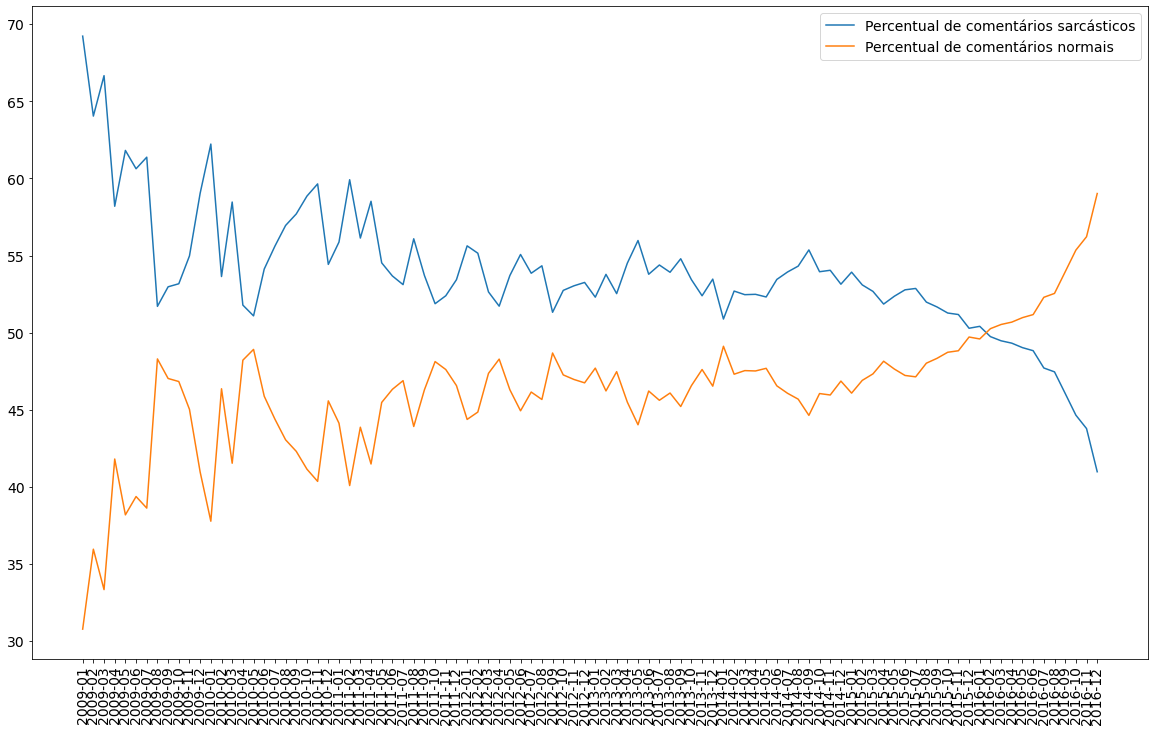

Percentualmente, os comentários sarcásticos têm diminuído ao longo do tempo.


In [13]:
# 3. Percentualmente, ao longo do tempo os comentários sarcásticos tem aumentado ou diminuído?
# Plote um gráfico de sua preferência para mostrar a evolução.

evol_percent_sarcasticos = (df_comments[df_comments['label'] == 1].groupby('date')['label'].count()\
                            / df_comments.groupby('date')['label'].count()) * 100

evol_percent_normais = (df_comments[df_comments['label'] == 0].groupby('date')['label'].count()\
                                / df_comments.groupby('date')['label'].count()) * 100

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=[20,12])
sns.lineplot(data=evol_percent_sarcasticos, label='Percentual de comentários sarcásticos')
sns.lineplot(data=evol_percent_normais, label='Percentual de comentários normais')
plt.xticks(rotation=90)
plt.show()

print('Percentualmente, os comentários sarcásticos têm diminuído ao longo do tempo.')

In [14]:
# 4. Percentualmente, olhando a variável subreddit, qual o assunto que mais gera comentários
# sarcásticos? Considere apenas assuntos com mais de 1000 comentários.

# VERIFICANDO ASSUNTOS QUE POSSUEM MAIS DE 1000 COMENTÁRIOS 
# E CRIANDO DATAFRAME COM A QUANTIDADE DOS COMENTÁRIOS
df_nro_comments = pd.DataFrame(df_comments.groupby('subreddit')['comment'].count())

df_nro_comments = df_nro_comments[df_nro_comments['comment'] > 1000]

df_nro_sarcasticos = pd.DataFrame(df_comments[df_comments['label'] == 1].groupby('subreddit')['comment'].count())

df_nro = df_nro_comments.join(df_nro_sarcasticos, rsuffix='_sarcastic')

df_nro['percent_sarcastic'] = (df_nro['comment_sarcastic'] / df_nro['comment']) * 100

print('Assunto com mais de 1000 comentários que, percentualmente, gera mais comentários sarcásticos:')
print(df_nro.sort_values(by='percent_sarcastic', ascending=False).head(1))

Assunto com mais de 1000 comentários que, percentualmente, gera mais comentários sarcásticos:
           comment  comment_sarcastic  percent_sarcastic
subreddit                                               
creepyPMs     5466               4287          78.430296


In [15]:
# 5. Por tipo de comentário (sarcástico ou não), quantas palavras temos em média em
# comment_wcount e parent_comment_wcount?

print('Média da quantidade de palavras em comment_wcount para comentários normais:',
df_comments[df_comments['label'] == 0]['comment_wcount'].mean())

print('Média da quantidade de palavras em comment_wcount para comentários sarcásticos:',
df_comments[df_comments['label'] == 1]['comment_wcount'].mean())

print('\nMédia da quantidade de palavras em parent_comment_wcount para comentários normais:',
df_comments[df_comments['label'] == 0]['parent_comment_wcount'].mean())

print('Média da quantidade de palavras em parent_comment_wcount para comentários sarcásticos:',
df_comments[df_comments['label'] == 1]['parent_comment_wcount'].mean())

Média da quantidade de palavras em comment_wcount para comentários normais: 10.592042311208196
Média da quantidade de palavras em comment_wcount para comentários sarcásticos: 10.330915293409952

Média da quantidade de palavras em parent_comment_wcount para comentários normais: 24.562958302169775
Média da quantidade de palavras em parent_comment_wcount para comentários sarcásticos: 24.211416235297843


Média no campo comment_char (número de caracteres) em cada tipo de comentário:
Normais: 56.93518573480702
Sarcásticos: 56.44981083091925

Mediana no campo comment_char (número de caracteres) em cada tipo de comentário:
Normais: 44.0
Sarcásticos: 48.0 



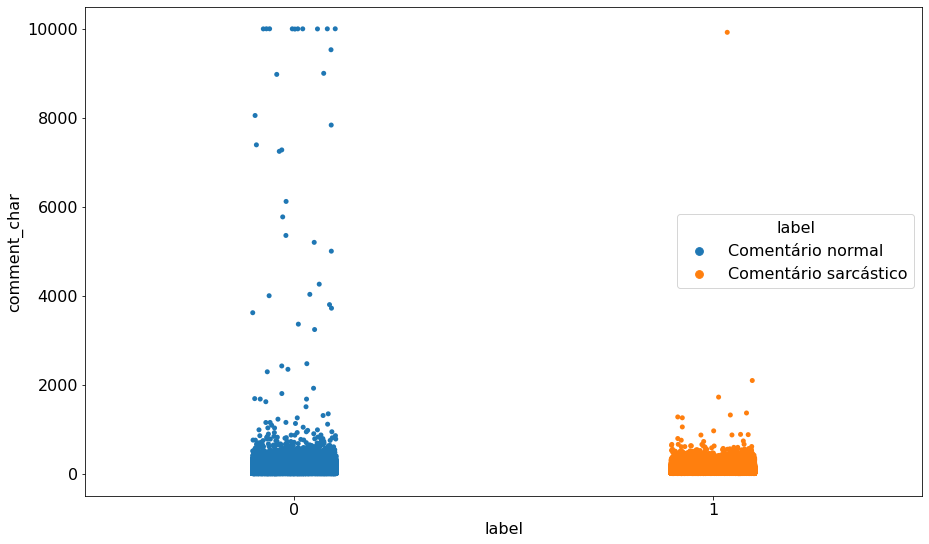

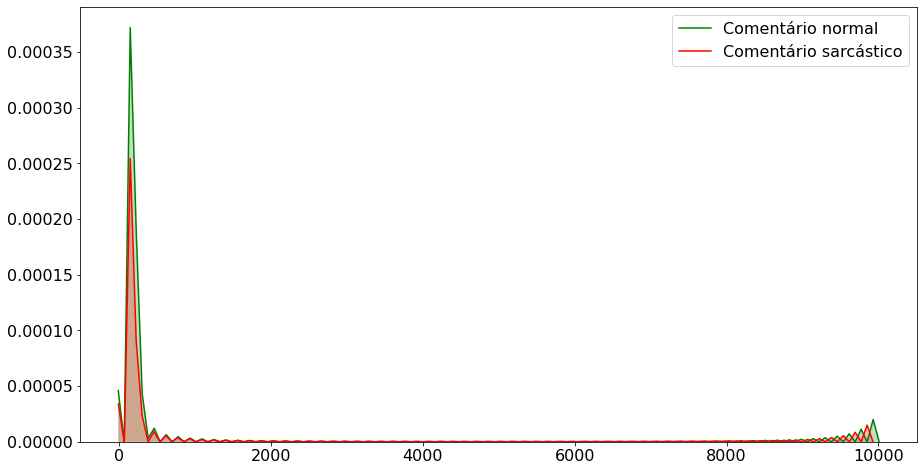

Analisando os gráficos e os dados, ainda que haja uma diferença pequena, é possível dizer que 
os comentários sarcásticos são levemente menores que os comentários normais.


In [21]:
# 6. Comentários sarcásticos são maiores ou menores em relação aos comentários normais? Use o
# campo comment_char criado anteriormente para mostrar essa relação através de gráficos de
# distribuição.

print('Média no campo comment_char (número de caracteres) em cada tipo de comentário:')
print('Normais:', df_comments[df_comments['label'] == 0]['comment_char'].mean())
print('Sarcásticos:', df_comments[df_comments['label'] == 1]['comment_char'].mean())

print('\nMediana no campo comment_char (número de caracteres) em cada tipo de comentário:')
print('Normais:', df_comments[df_comments['label'] == 0]['comment_char'].median())
print('Sarcásticos:', df_comments[df_comments['label'] == 1]['comment_char'].median(), '\n')

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[15,9])
sns.stripplot(data=df_comments, x='label', y='comment_char',
              hue=df_comments['label']\
              .mask(df_comments['label'] == 0, 'Comentário normal')\
              .mask(df_comments['label'] == 1, 'Comentário sarcástico'))
plt.show()

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,8))
sns.kdeplot(data=df_comments[df_comments['label'] == 0]['comment_char'],
            label='Comentário normal', shade=True, color='g')
sns.kdeplot(data=df_comments[df_comments['label'] == 1]['comment_char'],
            label='Comentário sarcástico', shade=True, color='r')
plt.show()

print('Analisando os gráficos e os dados, ainda que haja uma diferença pequena, é possível dizer que \n\
os comentários sarcásticos são levemente menores que os comentários normais.')

In [22]:
# 7. Se uníssimos comment e parent_comment em uma só mensagem, percentualmente em média,
# quanto representaria comment em relação a mensagem unida. Utilize os campos comment_char
# e parent_comment_char que criamos anteriormente.

print(((df_comments['comment_char']\
/(df_comments['comment_char'] + df_comments['parent_comment_char'])).mean()) * 100)

print('Em média, comment representa 38,42% da união entre comment e parent_comment.')

38.42105450220459
Em média, comment representa 38,42% da união entre comment e parent_comment.


### Pré-processamento para mineração de texto

In [23]:
# Aqui a ideia é aplicarmos o pipeline que aprendemos em aula:
# (A partir desse ponto, talvez seja necessário reduzir o tamanho da base de dados, uma vez que os
# próximos passos vão exigir maior capacidade computacional. Use uma técnica de amostragem simples,
# como pd.sample() por exemplo).

# Pegando uma amostra de 1% do dataframe

df_comments_am = df_comments.sample(frac=0.01, random_state=1)

# Arrumando índices e coluna label para evitar problemas mais a frente

df_comments_am.index = [i for i in range(len(df_comments_am))]

df_comments_am.rename(columns={'label':'LABEL'}, inplace=True)

df_comments_am

,LABEL,comment,author,subreddit,score,date,parent_comment,comment_wcount,parent_comment_wcount,comment_char,parent_comment_char
0,1,"Yes, more people die from war now than during ...",castledagger,technology,1.0,2013-05,"if you look at history, the more we take away ...",12,27,60,130
1,0,40lbs of pure fitness,marineturndlegofiend,funny,257.0,2015-06,Today I am a warrior princess.,4,6,21,30
2,1,I bet they ship NaLi,AstonishingSpiderMan,fairytail,7.0,2015-08,Some people just want to see the world burn.,5,9,20,44
3,0,Must've left the gallery before the part where...,BatCountryTourist,news,1.0,2016-10,So Seattle is pretty libertine. I've lived her...,27,73,164,388
4,0,I &lt;3 batman!,twin_sis,Vaping,2.0,2015-03,Any Bat-Fans out there?,3,4,15,23
...,...,...,...,...,...,...,...,...,...,...,...
10103,1,"Its Wednesday, no one practices....",ChazMan19,fantasyfootball,0.0,2015-11,Amari Cooper did not practice with a quadricep...,5,22,35,121
10104,0,First time it appeared on my map was when it b...,streamlin3d,europe,1.0,2016-02,"Most people have never even heard of Tallinn, ...",16,21,84,105
10105,1,Should have aimed pro side bro.,dankscott,discgolf,1.0,2016-05,Devastation!,6,1,31,12
10106,0,I feel I am tempting fate in hoping this won't...,funnynameguy,movies,1.0,2015-05,First image of David Levinson (Jeff Goldblum) ...,11,14,52,80


In [24]:
# 1. Crie uma função que faça as transformações necessárias no texto:
# a. Retire pontuações
# b. Remova stopwords
# c. Normalize no seu sentido mais abstrato (stemming)

def transfComment(msg):
    
    no_punctuation = [char for char in msg if char not in string.punctuation]
    
    no_punctuation = ''.join(no_punctuation)
    
    no_stopwords = [palavra for palavra in no_punctuation.split() if palavra.lower() 
                    not in stopwords.words('english')]
    
    st = PorterStemmer()
    return [st.stem(stPalavra) for stPalavra in no_stopwords]

df_comments_am['comment'].apply(transfComment).head()

0                     [ye, peopl, die, war, dark, age]
1                                    [40lb, pure, fit]
2                                    [bet, ship, nali]
3    [mustv, left, galleri, part, attende, turn, ho...
4                                        [lt3, batman]
Name: comment, dtype: object

In [25]:
# 2. Vetorize a mensagem por Word Count e aplique a função de transformação criada no passo anterior;

vetorizadorWC = CountVectorizer(analyzer=transfComment).fit(df_comments_am['comment'])

msVetWC = vetorizadorWC.transform(df_comments_am['comment'])

msVetWC.shape

(10108, 10618)

In [26]:
# 3. Transforme a matriz verotizada de WC em um dataframe e inclua o campo label;

msVetWCPandas = pd.DataFrame(msVetWC.todense(), columns=vetorizadorWC.get_feature_names())

msWC = pd.concat([df_comments_am['LABEL'], msVetWCPandas], axis=1)

msWC.head()

,LABEL,0,00,000,0001,00100000,00101100,00101110,008,010,...,zip,zipper,zo,zohan,zombi,zone,zoo,zoom,zulrah,zulu
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 4. Vetorize novamente os dados só que agora aplicando a equação TF-IDF;

vetorizadorTFIDF = TfidfTransformer().fit(msVetWC)

msVetTFIDF = vetorizadorTFIDF.transform(msVetWC)

msVetTFIDF.shape

(10108, 10618)

In [28]:
# 5. Transforme a matriz esparsa verotizada de TF-IDF em um dataframe e inclua o campo label;

msVetTFIDFPandas = pd.DataFrame(msVetTFIDF.todense(), columns=vetorizadorWC.get_feature_names())

msTFIDF = pd.concat([df_comments_am['LABEL'], msVetTFIDFPandas], axis=1)

msTFIDF.head()

,LABEL,0,00,000,0001,00100000,00101100,00101110,008,010,...,zip,zipper,zo,zohan,zombi,zone,zoo,zoom,zulrah,zulu
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# 6. Qual o top 5 de palavras com maiores valores de TF-IDF do primeiro documento listado?

documento = 0

top5 = pd.DataFrame(msVetTFIDF[documento].T.todense(), index=vetorizadorWC.get_feature_names(), columns=["tfidf"])

top5.sort_values(by=["tfidf"],ascending=False).head(5)

,tfidf
dark,0.496701
age,0.464179
die,0.415984
war,0.413309
ye,0.333916


### Mineração de texto

In [30]:
# Nosso objetivo é criar um modelo supervisionado que identifique se a mensagem é ou não sarcástica.
# 1. Escolha pelo menos dois algoritmos de classificação (pesquise na comunidade quais técnicas são
# mais indicadas para text mining).

# Serão utilizados os classificadores Naive Bayes Multinomial e Floresta Aleatória

In [31]:
# 2. Para cada algoritmo, treine um modelo utilizando a matriz vetorizada WC e faça o mesmo com a
# matriz TF-IDF, compare os resultados.

#
# Utilizando Matriz Vetorizada WC
#

x_train, x_test, y_train, y_test = train_test_split(
                                   msWC.drop(columns='LABEL'), msWC['LABEL'],
                                   train_size=0.5, random_state=0)

modelo_nb_wc = MultinomialNB()
modelo_nb_wc.fit(x_train, y_train)
preds = modelo_nb_wc.predict(x_test)

acc = accuracy_score(y_test, preds)
print('Acurácia MultinomialNB WC: {:.2f}%'.format(acc*100))
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

modelo_rf_wc = RandomForestClassifier(n_estimators=500)
modelo_rf_wc.fit(x_train, y_train)
preds = modelo_rf_wc.predict(x_test)

acc = accuracy_score(y_test, preds)
print('\nAcurácia RandomForest WC: {:.2f}%'.format(acc*100))
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

#
# Utilizando matriz TF-IDF
#

x_train, x_test, y_train, y_test = train_test_split(
                                   msTFIDF.drop(columns='LABEL'), msTFIDF['LABEL'],
                                   train_size=0.5, random_state=0)

modelo_nb_tfidf = MultinomialNB()
modelo_nb_tfidf.fit(x_train, y_train)
preds = modelo_nb_tfidf.predict(x_test)

acc = accuracy_score(y_test, preds)
print('\nAcurácia MultinomialNB TF-IDF: {:.2f}%'.format(acc*100))
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

modelo_rf_tfidf = RandomForestClassifier(n_estimators=500)
modelo_rf_tfidf.fit(x_train, y_train)
preds = modelo_rf_tfidf.predict(x_test)

acc = accuracy_score(y_test, preds)
print('\nAcurácia RandomForest TF-IDF: {:.2f}%'.format(acc*100))
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

Acurácia MultinomialNB WC: 60.66%
[[1300 1253]
 [ 735 1766]]

Acurácia RandomForest WC: 60.88%
[[1882  671]
 [1306 1195]]

Acurácia MultinomialNB TF-IDF: 61.73%
[[1637  916]
 [1018 1483]]

Acurácia RandomForest TF-IDF: 61.65%
[[1996  557]
 [1381 1120]]


In [ ]:
# É possível notar que os classificadores tiveram resultados muito semelhantes no quesito
# acurácia quando utilizaram a mesma matriz, ainda que os valores de falsos positivos e
# falsos negativos estejam bem distintos.
# Quando comparados os resultados entre as matrizes, ambos modelos tiveram melhora de
# cerca de 1% ao se utilizarem da matriz TF-IDF no lugar da matriz WC.